In [1]:
import scipy
from scipy.interpolate import CubicHermiteSpline, PPoly, interp1d
from scipy.integrate import solve_ivp, ode, odeint
import jax
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

# plotting the lyapunov verification region
from python_lyapunov import *
from python_tvlqr import *
from plan_utility import acrobot_obs 
# read the data obtained from sparse_rrt
dynamics = acrobot_obs.dynamics
jax_dynamics = acrobot_obs.jax_dynamics
enforce_bounds = acrobot_obs.enforce_bounds


In [3]:




f = open('../data/acrobot_obs/0/path_5.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
#for i in range(len(x)):
#    x[i][0] = x[i][0] / 30.
#    x[i][1] = x[i][1] / 30.  # normalize state and velocity
f = open('../data/acrobot_obs/0/control_5.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../data/acrobot_obs/0/cost_5.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()
"""
# cartpole
f = open('../../data/cartpole/0/path_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
f = open('../../data/cartpole/0/control_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../../data/cartpole/0/cost_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()
goal = x[-1]
#goal = sg[-1]
"""


new_x = []
new_u = []
new_dt = []
new_x0 = x[0]
new_x.append(new_x0)
# what if we only look at the first segment

x0 = x[0]
xT = x[-1]
print('previous xT:')
print(xT)
step_sz = 0.02
for i in range(len(dt)):
    for j in range(int(dt[i]/step_sz)):
        new_x0 = new_x0 + step_sz*dynamics(new_x0, u[i])
        new_x0 = enforce_bounds(new_x0)
        new_x.append(new_x0)
        new_u.append(u[i])
        new_dt.append(step_sz)
    #new_x.append(new_x0)
    #new_u.append(u[i])
    #new_dt.append(dt[i])
x = new_x
u = new_u
dt = new_dt
goal = x[-1]

time_knot = np.cumsum(new_dt)
time_knot = np.insert(time_knot, 0, 0.)
print(time_knot)
# obtain a lqr for end position
#A = jax.jacfwd(jaxfunc, argnums=0)(xtraj(time_knot[-1]), utraj(time_knot[-1]))
#B = jax.jacfwd(jaxfunc, argnums=1)(xtraj(time_knot[-1]), utraj(time_knot[-1]))
jac_A = jax.jacfwd(jax_dynamics, argnums=0)
jac_B = jax.jacfwd(jax_dynamics, argnums=1)

controller, xtraj, utraj, S = tvlqr(x, u, dt, dynamics, jac_A, jac_B)


previous xT:
[ 2.22421447  0.97614701  0.85903613 -2.36707156]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.   2.02 2.04 2.06 2.08 2.1  2.12 2.14 2.16 2.18 2.2  2.22
 2.24 2.26 2.28 2.3  2.32 2.34 2.36 2.38 2.4  2.42 2.44 2.46 2.48 2.5
 2.52 2.54 2.56 2.58 2.6  2.62 2.64 2.66 2.68 2.7  2.72 2.74 2.76 2.78
 2.8  2.82 2.84 2.86 2.88 2.9  2.92 2.94 2.96 2.98 3.   3.02 3.04 3.06
 3.08 3.1  3.12 3.14 3.16 3.18 3.2  3.22 3.24 3.26 3.28 3.3  3.32 3.34
 3.36 3.38 3.4  3.42 3.44 3.46 3.48 3.5  3.52 3.54 3.56 3.58 3.6  3.62
 3.64 3.66 3.68 

/home/arclabdl1/anaconda3/envs/ylmiao_kino/lib/python3.6/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
#print(x)
#x = np.array(x)

#indices = np.arange(0, len(time_knot), 10)
#time_knot = time_knot[indices]
#print(time_knot)

In [5]:
#time_knot = np.append(time_knot, np.sum(new_dt))
# including the end index
#print(time_knot)

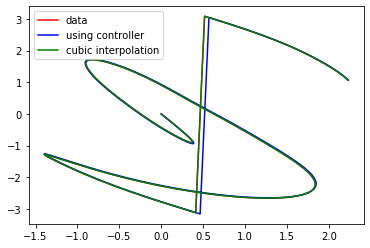

In [6]:
x = np.array(x)
plt.plot(x[:,0], x[:,1], 'r', label='data')

#num = 200
num = np.sum(dt) / step_sz
time_span = np.linspace(0, np.sum(dt), num+1)
delta_t = time_span[-1] / num
actual_x = np.array(x0)
xs = []
xs.append(actual_x)
real_xs = []
# plot data
for i in range(len(time_span)):
    u = controller(time_span[i], actual_x)
    #print('current state:')
    #print(x)
    #print('tracked traj:')
    #print(x_traj(time_span[i]))
    xdot = dynamics(actual_x, u)
    actual_x = actual_x + xdot * delta_t
    xs.append(actual_x)
    real_xs.append(xtraj(time_span[i]))
    actual_x = enforce_bounds(actual_x)
xs = np.array(xs)
real_xs = np.array(real_xs)
#print(xs)
#print(real_xs)
plt.plot(xs[:,0], xs[:,1], 'b', label='using controller')
plt.plot(real_xs[:,0], real_xs[:,1], 'g', label='cubic interpolation')
plt.legend()

In [7]:

def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller.

    dx/dt = A x + B u

    cost = integral x.T*Q*x + u.T*R*u
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)

    return K, X, eigVals


xG = np.array(goal)
uG = np.zeros((1))
uG = np.array([0.])
#uG = stable_u(xG)
print(dynamics(xG, uG))
A = jax.jacfwd(jax_dynamics, argnums=0)(xG, uG)
B = jax.jacfwd(jax_dynamics, argnums=1)(xG, uG)

A = np.asarray(A)
B = np.asarray(B)
Q = np.identity(len(x[0]))
R = np.identity(len(uG))
K, lqr_S, E = lqr(A, B, Q, R)

#print(dynamics(xtraj(time_knot[-1]), utraj(time_knot[-1])))
lqr_rho = sample_ti_verify(xG, uG, lqr_S, K, dynamics, numSample=1000)
# create a funnel that guides
upper_rho = lqr_rho
upper_x = xG
upper_S = np.identity(len(lqr_S))
lqr_S = np.identity(len(lqr_S))
# in cartpole problem, we may not be able to stablize around the endpoint, set it to a large value
print(lqr_rho)
upper_rho = 1.5
tvlqr_rhos = []
print(len(time_knot))

for i in range(len(time_knot)-1,0,-1):
    print('knot %d' % (i))
    t0 = time_knot[i-1]
    t1 = time_knot[i]
    x0 = xtraj(t0)
    u0 = utraj(t0)
    x1 = xtraj(t1)
    u1 = utraj(t1)
    A0 = jax.jacfwd(jax_dynamics, argnums=0)(x0, u0)
    B0 = jax.jacfwd(jax_dynamics, argnums=1)(x0, u0)
    A1 = jax.jacfwd(jax_dynamics, argnums=0)(x1, u1)
    B1 = jax.jacfwd(jax_dynamics, argnums=1)(x1, u1)
    A0 = np.asarray(A0)
    B0 = np.asarray(B0)
    A1 = np.asarray(A1)
    B1 = np.asarray(B1)

    S0 = S(t0).reshape(len(x0),len(x0))
    S1 = S(t1).reshape(len(x0),len(x0))
    
    rho0, rho1 = sample_tv_verify(t0, t1, upper_x, upper_S, upper_rho, S0, S1, A0, A1, B0, B1, R, Q, x0, x1, u0, u1, func=dynamics, system=None, numSample=100)
    upper_rho = rho0
    upper_x = x0
    upper_S = S0
    #tvlqr_rhos.append([rho0, rhodot0, rho1, rhodot1, t0, t1])
    tvlqr_rhos.append([rho0, rho1, t0, t1])
    
    


[ 0.81379501 -2.15599    -8.0340074  10.13294383]
0.001
251
knot 250
delta:
2.220446049250313e-16
upper_rho
1.5
knot 249
delta:
0.0
upper_rho
1.3830668067358474
knot 248
delta:
0.0
upper_rho
1.316665252101925
knot 247
delta:
0.0
upper_rho
1.2238554263609867
knot 246
delta:
0.0
upper_rho
1.1746915450061608
knot 245
delta:
0.0
upper_rho
1.1282449895041349
knot 244
delta:
0.0
upper_rho
1.072694461703516
knot 243
delta:
0.0
upper_rho
1.0380124932498827
knot 242
delta:
0.0
upper_rho
0.994607733285384
knot 241
delta:
0.0
upper_rho
0.962065177498173
knot 240
delta:
0.0
upper_rho
0.9263258820470098
knot 239
delta:
0.0
upper_rho
0.9095828798554486
knot 238
delta:
0.0
upper_rho
0.8810157159411109
knot 237
delta:
0.0
upper_rho
0.8644738403990461
knot 236
delta:
0.0
upper_rho
0.8425584651076631
knot 235
delta:
0.0
upper_rho
0.8170218664013849
knot 234
delta:
0.0
upper_rho
0.7873043125658634
knot 233
delta:
0.0
upper_rho
0.7698505607201387
knot 232
delta:
0.0
upper_rho
0.7475629398251571
knot 231
d

In [8]:
print(time_knot)
print(xtraj(0))
print(x[0])

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.   2.02 2.04 2.06 2.08 2.1  2.12 2.14 2.16 2.18 2.2  2.22
 2.24 2.26 2.28 2.3  2.32 2.34 2.36 2.38 2.4  2.42 2.44 2.46 2.48 2.5
 2.52 2.54 2.56 2.58 2.6  2.62 2.64 2.66 2.68 2.7  2.72 2.74 2.76 2.78
 2.8  2.82 2.84 2.86 2.88 2.9  2.92 2.94 2.96 2.98 3.   3.02 3.04 3.06
 3.08 3.1  3.12 3.14 3.16 3.18 3.2  3.22 3.24 3.26 3.28 3.3  3.32 3.34
 3.36 3.38 3.4  3.42 3.44 3.46 3.48 3.5  3.52 3.54 3.56 3.58 3.6  3.62
 3.64 3.66 3.68 3.7  3.72 3.74 3.76 3.78 3.8  3.82 3.84 3.86 3.88 3.9
 3.92 3.9

4.979999999999982
4.982222222222204
4.984444444444426
4.986666666666649
4.98888888888887
4.991111111111093
4.9933333333333145
4.995555555555537
4.997777777777759
4.999999999999981
4.959999999999982
4.962222222222205
4.9644444444444265
4.966666666666649
4.968888888888871
4.971111111111093
4.973333333333315
4.9755555555555375
4.977777777777759
4.979999999999982
4.939999999999983
4.942222222222205
4.944444444444427
4.9466666666666494
4.948888888888871
4.951111111111094
4.953333333333315
4.955555555555538
4.95777777777776
4.959999999999982
4.919999999999983
4.922222222222206
4.924444444444427
4.92666666666665
4.9288888888888716
4.931111111111094
4.933333333333316
4.935555555555538
4.93777777777776
4.939999999999983
4.8999999999999835
4.902222222222206
4.904444444444428
4.90666666666665
4.908888888888872
4.9111111111110946
4.913333333333316
4.915555555555539
4.9177777777777605
4.919999999999983
4.879999999999984
4.8822222222222065
4.884444444444428
4.886666666666651
4.888888888888872
4.8911

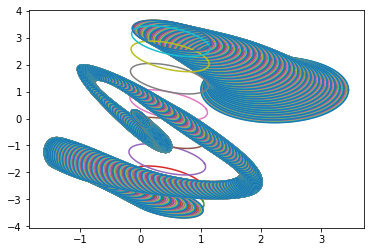

In [9]:
from scipy.interpolate import CubicHermiteSpline
# plot lqr_rho
# sampling points in the epplisolid (x-xG)TS(x-xG)=rho

def plot_ellipsoid(S, rho, x0, alpha=1.0):
    theta = np.linspace(0, np.pi*2, 100)
    U = [np.cos(theta), np.sin(theta), np.zeros(100), np.zeros(100)]
    U = np.array(U).T
    tmp = np.linalg.pinv(S)
    tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
    S_invsqrt = scipy.linalg.sqrtm(tmp)
    X = U @ S_invsqrt  # 100x2
    X = np.sqrt(rho)*X + x0
    plt.plot(X[:,0],X[:,1], alpha=alpha)

plot_ellipsoid(lqr_S, lqr_rho, xG)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t)



t0:
0.0
0-th sample
num: 250
1-th sample
num: 250
2-th sample
num: 250
3-th sample
num: 250
4-th sample
num: 250
5-th sample
num: 250
6-th sample
num: 250
7-th sample
num: 250
8-th sample
num: 250
9-th sample
num: 250
4.979999999999982
4.982222222222204
4.984444444444426
4.986666666666649
4.98888888888887
4.991111111111093
4.9933333333333145
4.995555555555537
4.997777777777759
4.999999999999981
4.959999999999982
4.962222222222205
4.9644444444444265
4.966666666666649
4.968888888888871
4.971111111111093
4.973333333333315
4.9755555555555375
4.977777777777759
4.979999999999982
4.939999999999983
4.942222222222205
4.944444444444427
4.9466666666666494
4.948888888888871
4.951111111111094
4.953333333333315
4.955555555555538
4.95777777777776
4.959999999999982
4.919999999999983
4.922222222222206
4.924444444444427
4.92666666666665
4.9288888888888716
4.931111111111094
4.933333333333316
4.935555555555538
4.93777777777776
4.939999999999983
4.8999999999999835
4.902222222222206
4.904444444444428
4.9066

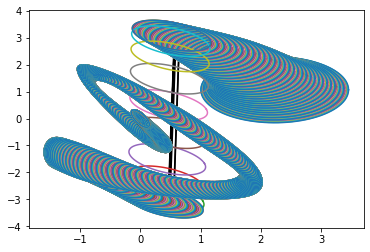

In [10]:

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
X0 = np.sqrt(1e-2)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/step_sz
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    #print(xs)
    #print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')

plot_ellipsoid(lqr_S, lqr_rho, xG)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        #rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t)



In [11]:
def plot_ellipsoid(S, rho, x0, alpha=1.0):
    theta = np.linspace(0, np.pi*2, 100)
    U = [np.cos(theta), np.sin(theta), np.zeros(100), np.zeros(100)]
    U = np.array(U).T
    tmp = np.linalg.pinv(S)
    tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
    S_invsqrt = scipy.linalg.sqrtm(tmp)
    X = U @ S_invsqrt  # 100x2
    X = np.sqrt(rho)*X + x0
    plt.plot(X[:,0],X[:,1], alpha=alpha)


4.979999999999982
4.982222222222204
4.984444444444426
4.986666666666649
4.98888888888887
4.991111111111093
4.9933333333333145
4.995555555555537
4.997777777777759
4.999999999999981
4.959999999999982
4.962222222222205
4.9644444444444265
4.966666666666649
4.968888888888871
4.971111111111093
4.973333333333315
4.9755555555555375
4.977777777777759
4.979999999999982
4.939999999999983
4.942222222222205
4.944444444444427
4.9466666666666494
4.948888888888871
4.951111111111094
4.953333333333315
4.955555555555538
4.95777777777776
4.959999999999982
4.919999999999983
4.922222222222206
4.924444444444427
4.92666666666665
4.9288888888888716
4.931111111111094
4.933333333333316
4.935555555555538
4.93777777777776
4.939999999999983
4.8999999999999835
4.902222222222206
4.904444444444428
4.90666666666665
4.908888888888872
4.9111111111110946
4.913333333333316
4.915555555555539
4.9177777777777605
4.919999999999983
4.879999999999984
4.8822222222222065
4.884444444444428
4.886666666666651
4.888888888888872
4.8911

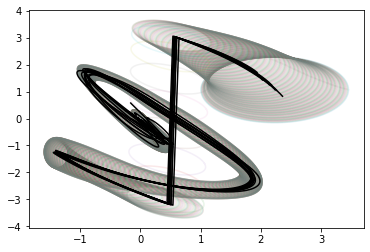

In [12]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.1)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 4.
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/step_sz
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')



In [13]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.1)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 64.
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/step_sz
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')



4.979999999999982
4.982222222222204
4.984444444444426
4.986666666666649
4.98888888888887
4.991111111111093
4.9933333333333145
4.995555555555537
4.997777777777759
4.999999999999981
4.959999999999982
4.962222222222205
4.9644444444444265
4.966666666666649
4.968888888888871
4.971111111111093
4.973333333333315
4.9755555555555375
4.977777777777759
4.979999999999982
4.939999999999983
4.942222222222205
4.944444444444427
4.9466666666666494
4.948888888888871
4.951111111111094
4.953333333333315
4.955555555555538
4.95777777777776
4.959999999999982
4.919999999999983
4.922222222222206
4.924444444444427
4.92666666666665
4.9288888888888716
4.931111111111094
4.933333333333316
4.935555555555538
4.93777777777776
4.939999999999983
4.8999999999999835
4.902222222222206
4.904444444444428
4.90666666666665
4.908888888888872
4.9111111111110946
4.913333333333316
4.915555555555539
4.9177777777777605
4.919999999999983
4.879999999999984
4.8822222222222065
4.884444444444428
4.886666666666651
4.888888888888872
4.8911

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb084b15268> (for post_execute):


KeyboardInterrupt: 

In [ ]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.4)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 625
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/step_sz
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')



In [ ]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.4)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 2500
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/step_sz
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')



In [ ]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.1)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 1e4
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/step_sz
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')

